# Preparing the Bathymetry Map for the Lake Mille Lacs Area of Interest

Author: Gregor Beyerle

Date: 2022-06-09

## Overview

This notebook contains the preparation of the bathymetry map for our area of interest: Lake Mille Lacs, a large lake in the U.S. state of Minnesota. I chose this AOI because in addition to being a large inland water body it is also relatively shallow in respect to other lakes in region. Because it proved to be a rather difficult target for the methods I examine in this project I also added the Bahamas and Puerto Rico AOIs to establish a clear baseline. I sourced the bathymetry map for this lake from [bathybase](http://www.bathybase.org).

In [8]:
import os
import sys
import dotenv

from eolearn.core import (
    FeatureType,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    SaveTask,
    OverwritePermission
)
from eolearn.io import ImportFromTiffTask, VectorImportTask
from eolearn.geometry import VectorToRasterTask

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import geopandas as gpd

This notebook uses functionality of both the `eolearn_extras` module as well as the `sdb_utils` module. It is important to add the relative location of the repository's root directory to the `sys.path` and import `eolearn_extras` before `sdb_utils` as some functions in this module reference `eolearn_extras`.

In [13]:
root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.display_map import display_bounding_box_for_gpd

The data for this project can - depending on whether you work with the complete dataset or only the preprocessed data - be roughly 13 GB on disk. This makes it necessary to distribute data individually from the repository and therefore the location of the data root directory might differ from setup to setup. This repository uses a `.env` file to configure the individual data root directory location. You need to add the `.env` file to your `notebooks` directory and add a line containing the needed information as a line following the pattern `data_root=<path-to-your-data-root>` in order for this notebook to work correctly.

In [6]:
dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

I prepared the bounding box of the AOI beforehand in QGIS. As I am only using this as a basis for visualization the AOI on a map I do not need to reproject it to the CRS of the selected Sentinel-2 scene.

In [11]:
mille_lacs_aoi_df = gpd.read_file(os.path.join(data_root_path, 'shapes', 'sdb_mille_lacs_aoi.shp'))
mille_lacs_aoi_df.total_bounds

array([ 436481.4789, 5106408.1539,  464413.103 , 5135108.0354])

On the map below you can see the AOI north of Andros island.

In [14]:
display_bounding_box_for_gpd(mille_lacs_aoi_df)

In [12]:
bathy_feature = (FeatureType.DATA_TIMELESS, 'bathy_data')
import_millie_lacs = ImportFromTiffTask(
    bathy_feature,
    os.path.abspath(os.path.join(data_root_path, 'mille_lacs.tiff')),
)

reproject_bathy = eolx.raster.ReprojectRasterTask(
    bathy_feature,
    target_resolution=(10, 10),
    target_crs='EPSG:32615',
)

append_bathy_data_mask = eolx.bathybase.AppendBathyTimelessDataMask(
    bathy_feature,
    band_index=0
)


output_label = 'millie_lacs_eop'
nodes = linearly_connect_tasks(
    import_millie_lacs,
    reproject_bathy,
    append_bathy_data_mask,
    OutputTask('millie_lacs_eop')
)
workflow = EOWorkflow(nodes)

worfklow_result = workflow.execute()
millie_lacs_eop = worfklow_result.outputs[output_label]

millie_lacs_eop

EOPatch(
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  bbox=BBox(((436481.2917158468, 5106398.21482021), (464421.2917158468, 5135108.21482021)), crs=CRS('32615'))
)

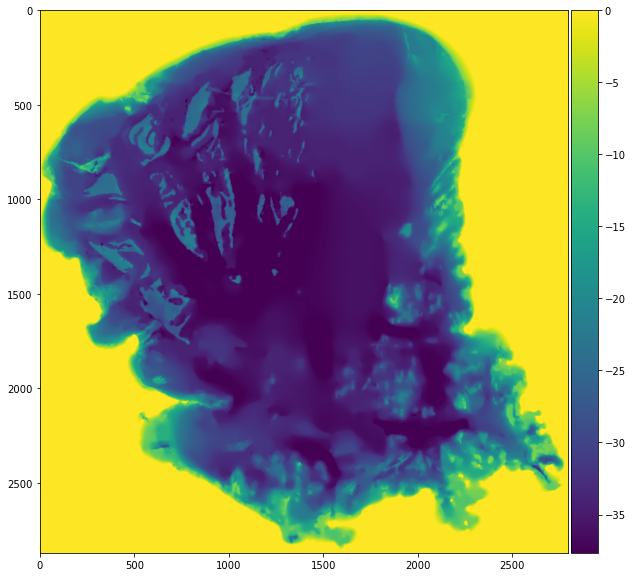

In [13]:
eolx.visualization.plot_single_band(millie_lacs_eop, bathy_feature, cmap='viridis')
plt.show()

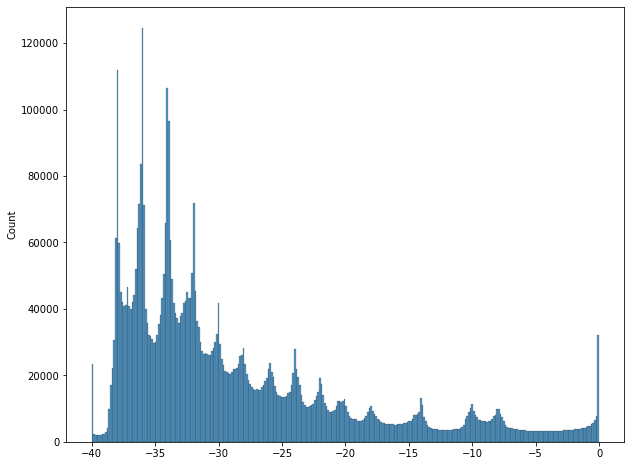

In [14]:
plt.figure(figsize=(10, 8))
sns.histplot(millie_lacs_eop[bathy_feature][millie_lacs_eop[bathy_feature] < 0].flatten())
plt.show()

In [15]:
bathy_shape_path = os.path.abspath(
    os.path.join(data_root_path, 'shapes', 'vectorized_outline_mille_lacs_minus_30m_buffer.shp')
)
read_bathy_shape = VectorImportTask(
    (FeatureType.VECTOR_TIMELESS, 'bathy_shape_minus_30m_buffer'),
    path=bathy_shape_path
)
read_bathy_shape.execute(millie_lacs_eop)

EOPatch(
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  vector_timeless={
    bathy_shape_minus_30m_buffer: geopandas.GeoDataFrame(columns=['fid', 'DN', 'geometry'], length=1, crs=EPSG:32615)
  }
  bbox=BBox(((436481.2917158468, 5106398.21482021), (464421.2917158468, 5135108.21482021)), crs=CRS('32615'))
)

In [16]:
vector_to_raster = VectorToRasterTask(
    (FeatureType.VECTOR_TIMELESS, 'bathy_shape_minus_30m_buffer'),
    (FeatureType.MASK_TIMELESS, 'buffered_bathy_mask'),
    raster_resolution=(10, 10),
    raster_dtype=np.uint8,
    values=1,
    no_data_value=0
)
vector_to_raster.execute(millie_lacs_eop)

EOPatch(
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    buffered_bathy_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  vector_timeless={
    bathy_shape_minus_30m_buffer: geopandas.GeoDataFrame(columns=['fid', 'DN', 'geometry'], length=1, crs=EPSG:32615)
  }
  bbox=BBox(((436481.2917158468, 5106398.21482021), (464421.2917158468, 5135108.21482021)), crs=CRS('32615'))
)

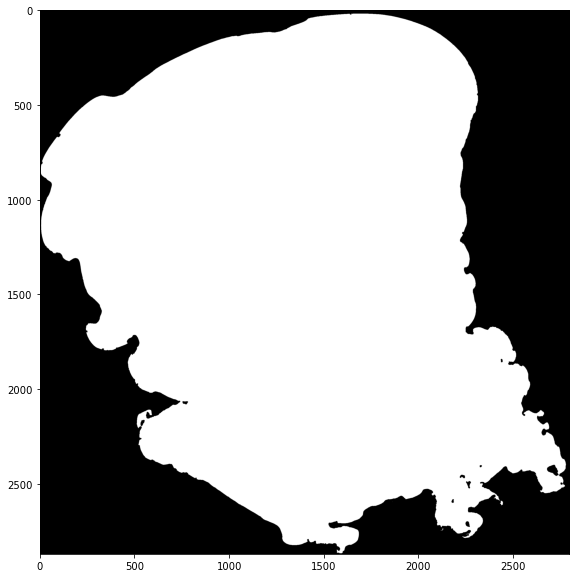

In [17]:
eolx.visualization.plot_single_band(
    millie_lacs_eop,
    (FeatureType.MASK_TIMELESS, 'buffered_bathy_mask'),
    colorbar=False,
    stretch=False
)
plt.show()

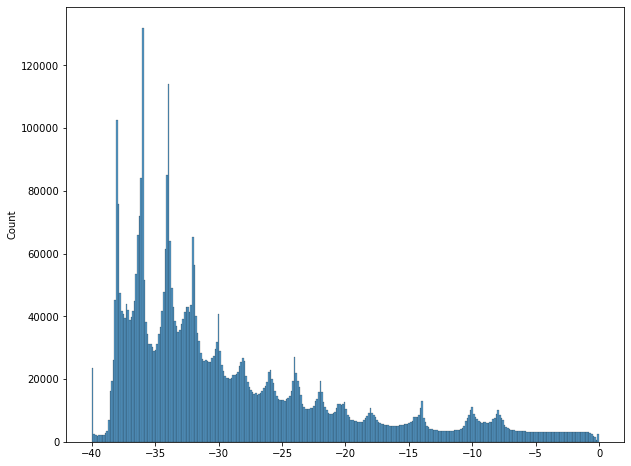

In [18]:
plt.figure(figsize=(10, 8))
sns.histplot(millie_lacs_eop[bathy_feature][millie_lacs_eop[(FeatureType.MASK_TIMELESS, 'buffered_bathy_mask')] == 1].flatten())
plt.show()

In [19]:
del millie_lacs_eop[(FeatureType.VECTOR_TIMELESS, 'bathy_shape_minus_30m_buffer')]
output_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'mille_lacs_bathy_eop')
)
save_eop = SaveTask(
    output_path,
    overwrite_permission=OverwritePermission.OVERWRITE_PATCH
)
save_eop.execute(millie_lacs_eop)

EOPatch(
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    buffered_bathy_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  bbox=BBox(((436481.2917158468, 5106398.21482021), (464421.2917158468, 5135108.21482021)), crs=CRS('32615'))
)